# 0 라이브러리 임포트 

In [7]:
# 필요한 라이브러리를 임포트합니다.
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import numpy as np  # 수치 계산을 위한 라이브러리
import wfdb  # 심전도 데이터를 읽기 위한 라이브러리
import ast  # 문자열 형태의 파이썬 표현식을 파싱하기 위한 라이브러리
from tqdm import tqdm  # 반복 작업의 진행 상황을 시각적으로 표시하기 위한 라이브러리
import warnings; warnings.filterwarnings('ignore')  # 경고 메시지를 무시하기 위한 설정
from IPython.display import display  # Jupyter 노트북에서 데이터를 깔끔하게 보여주기 위한 함수
from glob import glob # 하위 디렉토리에 파일을 가져와서 다루기위한 라이브러리 
import os # 현재 워킹디렉토리의 경로와 파일을 다루기 위한 라이브러리 
import h5py #.h5파일을 다루기 위한 라이브러리 
import gc #가비치 컬렉터를 다루는 라이브러리
import random


# 데이터 시각화를 위한 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt  # 그래프를 그리기 위한 라이브러리
import seaborn as sns  # matplotlib 기반의 고급 시각화 라이브러리

#머신러닝을 위한 scikit-learn 임포트 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# 파이토치를 위한 라이브러리 임포트 
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset # 텐서데이터셋
import torch.optim as optim

# 평가 지표 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc


In [2]:
## 모델 시드 고정 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. 데이터 전처리 
- 1-1 데이터 불러오기 

## 1-1 데이터 불러오기 및 전처리

In [ ]:
##ptb 데이터 프레임 로드 
'''
# 데이터 프레임 로드
path = './ptb_xl_data/'
df_ptb = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

# 파일 이름 리스트 변환
filenames = df_ptb['filename_hr'].tolist()
base_path = './ptb_xl_data/'

# Lead I 신호를 저장할 배열 초기화
lead1_signals = []

# 각 파일에서 Lead I 신호 추출
for filename in tqdm(filenames):
    signal, meta = wfdb.rdsamp(base_path + filename)

    # 신호 데이터 타입을 float32로 변경
    # signal = signal.astype(np.float32)
    
    lead1 = signal[:, 0]  # Lead I 신호 추출
    lead1_signals.append(lead1)

    # 사용하지 않는 변수 해제
    # del signal, meta
    # gc.collect()  # 가비지 컬렉터 실행


# 배열을 numpy 배열로 변환
df_ptb_lead1 = np.array(lead1_signals)

# 최종 배열 형태 확인
print("Final array shape:", df_ptb_lead1.shape)
'''

In [ ]:
## sph 데이터 로드 
'''
# .h5 파일 목록 가져오기
filenames = sorted(glob("./sph_data/records_sph/*.h5"))

# 메타데이터 로드 및 파일명 열 추가
df_sph = pd.read_csv("./sph_data/metadata.csv")
df_sph['filename'] = filenames

# Lead I 신호를 저장할 배열 초기화
lead1_signals_sph = []

# 각 파일에서 Lead I 신호 추출
for filename in tqdm(df_sph['filename']):
    with h5py.File(filename, 'r') as f:
        signal = f['ecg'][:].T

    lead1 = signal[:, 0]  # Lead I 신호 추출

    # 데이터 길이에 따른 처리
    if lead1.shape[0] == 5000:
        pass
    else:
        start_idx = np.random.randint(0, lead1.shape[0] - 4999)
        lead1 = lead1[start_idx:start_idx+5000]

    lead1_signals_sph.append(lead1)

# 배열을 numpy 배열로 변환
df_sph_lead1 = np.array(lead1_signals_sph)

# 최종 배열 형태 확인 및 저장
print("Final array shape:", df_sph_lead1.shape)
'''


In [3]:
## ptb,sph데이터 

# 데이터 프레임 로드
path = './ptb_xl_data/'
df_ptb = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
df_sph = pd.read_csv("./sph_data/metadata.csv")


In [4]:
# str (문자열) 코드를 딕셔너리로 변환 
df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))

# 딕셔너리에서 라벨 추출 ()
df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))

# 심방세동 라벨 컬럼 생성 (정답 컬럼)
df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

# 밸류값 확인
df_ptb.label.value_counts()

label
0    20285
1     1514
Name: count, dtype: int64

In [5]:
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)

#밸류값 확인 
df_sph.label.value_counts()

label
0    25095
1      675
Name: count, dtype: int64

In [6]:
## 보경님 코드를 이용한 전처리 

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df_ptb['label'].values

lead1_signals_float=lead1_signals.astype(np.float32)



# 데이터 정규화
lead1_signals_normalized = (lead1_signals_float - lead1_signals_float.mean()) / (lead1_signals_float.std()+1e-7)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
y = torch.Tensor(labels).long()  


# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 채널 수를 1로 추가_GOOD
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)




# 2 모델 생성

In [7]:

# 1D CNN 모델 정의
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 1250, 256)
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128,1)# 이진 분류를 위해 출력 차원을 1로 설정
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 128 * 1250 )
        x = F.leaky_relu(self.fc1(x))
        # x = self.fc2(x)
        x = F.leaky_relu(self.fc2(x)) # 이진 분류에서는 sigmoid 활성화 함수 사용
        x = self.fc3(x)
        return x


In [7]:
## 배치 정규화와 드롭아웃을 섞은 모델 
import torch.nn.functional as F

class BinaryCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(BinaryCNNWithBatchNormAndDropout, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(64)  # BatchNorm1d 추가
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(128)  # BatchNorm1d 추가
        self.fc1 = nn.Linear(128 * 1250, 256)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm3 = nn.BatchNorm1d(256)  # BatchNorm1d 추가
        self.dropout = nn.Dropout(0.5)  # Dropout 추가
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 128 * 1250)
        x = F.leaky_relu(self.batch_norm3(self.fc1(x)))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc3(x)
        return x

In [44]:
## 논문의 모델을 기반으로 만든 모델 

class Custom1DCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self):
        super(Custom1DCNNWithBatchNormAndDropout, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.5)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x


In [16]:
# 간단한 CNN 모델 구축
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=7, stride=2) 
        self.pool = torch.nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = torch.nn.Linear(64 * 2485, 1000) 
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2485)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# 논문에서 추출한 transfomer 모델
User
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from model_utils import PositionalEncoding, SelfAttentionPooling

class TransformerModel(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward, nlayers, n_conv_layers=2, n_class=2, dropout=0.5, dropout_other=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.n_class = n_class
        self.n_conv_layers = n_conv_layers
        self.relu = torch.nn.ReLU()
        self.pos_encoder = PositionalEncoding(748, dropout)
        self.pos_encoder2 = PositionalEncoding(6, dropout)
        self.self_att_pool = SelfAttentionPooling(d_model)
        self.self_att_pool2 = SelfAttentionPooling(d_model)
        encoder_layers = TransformerEncoderLayer(d_model=d_model, 
                                                 nhead=nhead, 
                                                 dim_feedforward=dim_feedforward, 
                                                 dropout=dropout
                                                 )
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder2 = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.flatten_layer = torch.nn.Flatten()
        # Define linear output layers
        if n_class == 2:
          self.decoder = nn.Sequential(nn.Linear(d_model, d_model), 
                                       nn.Dropout(dropout_other),
                                       nn.Linear(d_model, d_model), 
                                       nn.Linear(d_model, 64))
        # else:
        #   self.decoder = nn.Sequential(nn.Linear(d_model, d_model), nn.Dropout(0.1),
        #                                nn.Linear(d_model, d_model), nn.Dropout(0.1), 
        #                                nn.Linear(d_model, n_class))
        if n_class == 2:
          self.decoder2 = nn.Sequential(nn.Linear(d_model, d_model), 
                                       nn.Dropout(dropout_other),
                                      #  nn.Linear(d_model, d_model), 
                                       nn.Linear(d_model, 64))
        # Linear output layer after concat.
        self.fc_out1 = torch.nn.Linear(64+64, 64)
        self.fc_out2 = torch.nn.Linear(64, 1) # if two classes problem is binary  
        # self.init_weights()
        # Transformer Conv. layers
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.conv2 = torch.nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=3, stride=1, padding=1)
        self.conv = torch.nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=1, padding=0)
        # self.bn1 = nn.BatchNorm1d(128)
        # self.bn2 = nn.BatchNorm1d(d_model)
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        self.dropout = torch.nn.Dropout(p=0.1)
        # self.avg_maxpool = nn.AdaptiveAvgPool2d((64, 64))
        # RRI layers
        self.conv1_rri = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3)
        self.conv2_rri = torch.nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=3) 

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src2):      
        # src = self.encoder(src) * math.sqrt(self.d_model)
        # size input: [batch, sequence, embedding dim.]
        # src = self.pos_encoder(src) 
        # print('initial src shape:', src.shape)
        src = src.view(-1, 1, src.shape[1]) # Resize to --> [batch, input_channels, signal_length]
        src = self.relu(self.conv1(src))
        src = self.relu(self.conv2(src))
        # src = self.maxpool(self.relu(src))
        # print('src shape after conv1:', src.shape)
        for i in range(self.n_conv_layers):
          src = self.relu(self.conv(src))
          src = self.maxpool(src)

        # src = self.maxpool(self.relu(src))
        src = self.pos_encoder(src)   
        # print(src.shape) # [batch, embedding, sequence]
        src = src.permute(2,0,1) # reshape from [batch, embedding dim., sequnce] --> [sequence, batch, embedding dim.]
        # print('src shape:', src.shape)
        output = self.transformer_encoder(src) # output: [sequence, batch, embedding dim.], (ex. [3000, 5, 512])
        # print('output shape 1:', output.shape)
        # output = self.avg_maxpool(output)
        # output = torch.mean(output, dim=0) # take mean of sequence dim., output: [batch, embedding dim.] 
        output = output.permute(1,0,2)
        output = self.self_att_pool(output)
        # print('output shape 2:', output.shape)
        logits = self.decoder(output) # output: [batch, n_class]
        # print('output shape 3:', logits.shape)
        # output_softmax = nn.functional.softmax(logits, dim=1) # get prob. of logits dim.  # F.log_softmax(output, dim=0)
        # output = torch.sigmoid(output)
        # RRI layers
        src2 = src2.view(-1, 1, src2.shape[1]) # Resize to --> [batch, input_channels, signal_length]
        src2 = self.relu(self.conv1_rri(src2))
        src2 = self.relu(self.conv2_rri(src2))
        src2 = self.pos_encoder2(src2)  
        src2 = src2.permute(2,0,1) # reshape from [batch, embedding dim., sequnce] --> [sequence, batch, embedding dim.]
        output2 = self.transformer_encoder2(src2)
        output2 = output2.permute(1,0,2)
        output2 = self.self_att_pool2(output2)
        logits2 = self.decoder2(output2) # output: [batch, n_class]
        logits_concat = torch.cat((logits, logits2), dim=1)
        # Linear output layer after concat.
        xc = self.flatten_layer(logits_concat)
        # print('shape after flatten', xc.shape)
        xc = self.fc_out2(self.dropout(self.relu(self.fc_out1(xc)))) 


## 2-1 모델 학습

In [46]:
# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom1DCNNWithBatchNormAndDropout().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
criterion = torch.nn.BCEWithLogitsLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_aurocs = []

# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, np.round(train_preds))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    loss_check=[]
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    #print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation AUROC: {val_auroc:.4f}')
    val_aurocs.append(val_auroc)

Epoch 1/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.69it/s]


Epoch [1/10] - Validation AUROC: 0.7252


Epoch 2/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.98it/s]


Epoch [2/10] - Validation AUROC: 0.9667


Epoch 3/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.78it/s]


Epoch [3/10] - Validation AUROC: 0.9627


Epoch 4/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.71it/s]


Epoch [4/10] - Validation AUROC: 0.9755


Epoch 5/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.86it/s]


Epoch [5/10] - Validation AUROC: 0.9732


Epoch 6/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 59.24it/s]


Epoch [6/10] - Validation AUROC: 0.9835


Epoch 7/10 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.68it/s]


Epoch [7/10] - Validation AUROC: 0.9846


Epoch 8/10 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.04it/s]


Epoch [8/10] - Validation AUROC: 0.9815


Epoch 9/10 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.81it/s]


Epoch [9/10] - Validation AUROC: 0.9847


Epoch 10/10 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.17it/s]


Epoch [10/10] - Validation AUROC: 0.9879


In [36]:
# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom1DCNNWithBatchNormAndDropout().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
criterion = torch.nn.BCEWithLogitsLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_aurocs = []

# 조기 종료를 위한 변수 추가
best_val_loss = np.inf
patience = 5
counter = 0

# 학습 루프 설정
num_epochs = 50
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, np.round(train_preds))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())

            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')

    val_aurocs.append(val_auroc)

Epoch 1/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.18it/s]


Epoch [1/50] - Train Loss: 0.3001 - Train Accuracy: 0.9204 - Validation Loss: 0.2739 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5389


Epoch 2/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.71it/s]


Epoch [2/50] - Train Loss: 0.2580 - Train Accuracy: 0.9306 - Validation Loss: 0.2672 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5466


Epoch 3/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.14it/s]


Epoch [3/50] - Train Loss: 0.2573 - Train Accuracy: 0.9306 - Validation Loss: 0.2604 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5755


Epoch 4/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.70it/s]


Epoch [4/50] - Train Loss: 0.2557 - Train Accuracy: 0.9306 - Validation Loss: 0.2564 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5957


Epoch 5/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.93it/s]


Epoch [5/50] - Train Loss: 0.2571 - Train Accuracy: 0.9306 - Validation Loss: 0.2636 - Validation Accuracy: 0.9303 - Validation AUROC: 0.4984


Epoch 6/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.41it/s]


Epoch [6/50] - Train Loss: 0.2550 - Train Accuracy: 0.9306 - Validation Loss: 0.2657 - Validation Accuracy: 0.9294 - Validation AUROC: 0.5579


Epoch 7/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.63it/s]


Epoch [7/50] - Train Loss: 0.2521 - Train Accuracy: 0.9306 - Validation Loss: 0.2586 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5433


Epoch 8/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.93it/s]


Epoch [8/50] - Train Loss: 0.2550 - Train Accuracy: 0.9306 - Validation Loss: 0.2581 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5441


Epoch 9/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.86it/s]


Epoch [9/50] - Train Loss: 0.2528 - Train Accuracy: 0.9306 - Validation Loss: 0.2536 - Validation Accuracy: 0.9303 - Validation AUROC: 0.5887


Epoch 10/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.35it/s]


Epoch [10/50] - Train Loss: 0.2340 - Train Accuracy: 0.9304 - Validation Loss: 0.1375 - Validation Accuracy: 0.9298 - Validation AUROC: 0.9585


Epoch 11/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.27it/s]


Epoch [11/50] - Train Loss: 0.1393 - Train Accuracy: 0.9372 - Validation Loss: 0.2131 - Validation Accuracy: 0.8789 - Validation AUROC: 0.9452


Epoch 12/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.79it/s]


Epoch [12/50] - Train Loss: 0.1198 - Train Accuracy: 0.9441 - Validation Loss: 0.0998 - Validation Accuracy: 0.9569 - Validation AUROC: 0.9803


Epoch 13/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 63.05it/s]


Epoch [13/50] - Train Loss: 0.1071 - Train Accuracy: 0.9517 - Validation Loss: 0.1431 - Validation Accuracy: 0.9266 - Validation AUROC: 0.9688


Epoch 14/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.82it/s]


Epoch [14/50] - Train Loss: 0.1026 - Train Accuracy: 0.9526 - Validation Loss: 0.0822 - Validation Accuracy: 0.9693 - Validation AUROC: 0.9831


Epoch 15/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.90it/s]


Epoch [15/50] - Train Loss: 0.1016 - Train Accuracy: 0.9549 - Validation Loss: 0.0899 - Validation Accuracy: 0.9615 - Validation AUROC: 0.9822


Epoch 16/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.77it/s]


Epoch [16/50] - Train Loss: 0.0929 - Train Accuracy: 0.9601 - Validation Loss: 0.0802 - Validation Accuracy: 0.9670 - Validation AUROC: 0.9824


Epoch 17/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.97it/s]


Epoch [17/50] - Train Loss: 0.0913 - Train Accuracy: 0.9605 - Validation Loss: 0.1164 - Validation Accuracy: 0.9583 - Validation AUROC: 0.9741


Epoch 18/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.00it/s]


Epoch [18/50] - Train Loss: 0.0880 - Train Accuracy: 0.9627 - Validation Loss: 0.0853 - Validation Accuracy: 0.9628 - Validation AUROC: 0.9834


Epoch 19/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.49it/s]


Epoch [19/50] - Train Loss: 0.0836 - Train Accuracy: 0.9643 - Validation Loss: 0.0859 - Validation Accuracy: 0.9688 - Validation AUROC: 0.9844


Epoch 20/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.95it/s]


Epoch [20/50] - Train Loss: 0.0842 - Train Accuracy: 0.9657 - Validation Loss: 0.0881 - Validation Accuracy: 0.9587 - Validation AUROC: 0.9860


Epoch 21/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.92it/s]


Epoch [21/50] - Train Loss: 0.0774 - Train Accuracy: 0.9676 - Validation Loss: 0.1002 - Validation Accuracy: 0.9688 - Validation AUROC: 0.9802


Epoch 22/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.78it/s]


Epoch [22/50] - Train Loss: 0.0818 - Train Accuracy: 0.9670 - Validation Loss: 0.0771 - Validation Accuracy: 0.9706 - Validation AUROC: 0.9836


Epoch 23/50 - Training: 100%|██████████| 545/545 [00:09<00:00, 59.93it/s]


Epoch [23/50] - Train Loss: 0.0767 - Train Accuracy: 0.9694 - Validation Loss: 0.1315 - Validation Accuracy: 0.9385 - Validation AUROC: 0.9650


Epoch 24/50 - Training: 100%|██████████| 545/545 [00:09<00:00, 60.10it/s]


Epoch [24/50] - Train Loss: 0.0714 - Train Accuracy: 0.9714 - Validation Loss: 0.0726 - Validation Accuracy: 0.9725 - Validation AUROC: 0.9858


Epoch 25/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.90it/s]


Epoch [25/50] - Train Loss: 0.0693 - Train Accuracy: 0.9733 - Validation Loss: 0.0743 - Validation Accuracy: 0.9683 - Validation AUROC: 0.9856


Epoch 26/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.49it/s]


Epoch [26/50] - Train Loss: 0.0700 - Train Accuracy: 0.9723 - Validation Loss: 0.0742 - Validation Accuracy: 0.9706 - Validation AUROC: 0.9858


Epoch 27/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.67it/s]


Epoch [27/50] - Train Loss: 0.0677 - Train Accuracy: 0.9742 - Validation Loss: 0.0687 - Validation Accuracy: 0.9743 - Validation AUROC: 0.9808


Epoch 28/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.82it/s]


Epoch [28/50] - Train Loss: 0.0653 - Train Accuracy: 0.9748 - Validation Loss: 0.0728 - Validation Accuracy: 0.9734 - Validation AUROC: 0.9859


Epoch 29/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.78it/s]


Epoch [29/50] - Train Loss: 0.0687 - Train Accuracy: 0.9730 - Validation Loss: 0.0727 - Validation Accuracy: 0.9720 - Validation AUROC: 0.9870


Epoch 30/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.07it/s]


Epoch [30/50] - Train Loss: 0.0660 - Train Accuracy: 0.9740 - Validation Loss: 0.0730 - Validation Accuracy: 0.9693 - Validation AUROC: 0.9831


Epoch 31/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.82it/s]


Epoch [31/50] - Train Loss: 0.0639 - Train Accuracy: 0.9751 - Validation Loss: 0.0702 - Validation Accuracy: 0.9725 - Validation AUROC: 0.9882


Epoch 32/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 60.95it/s]


Epoch [32/50] - Train Loss: 0.0612 - Train Accuracy: 0.9761 - Validation Loss: 0.0713 - Validation Accuracy: 0.9734 - Validation AUROC: 0.9862


Epoch 33/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.88it/s]


Epoch [33/50] - Train Loss: 0.0603 - Train Accuracy: 0.9760 - Validation Loss: 0.0675 - Validation Accuracy: 0.9734 - Validation AUROC: 0.9885


Epoch 34/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.06it/s]


Epoch [34/50] - Train Loss: 0.0601 - Train Accuracy: 0.9759 - Validation Loss: 0.0679 - Validation Accuracy: 0.9757 - Validation AUROC: 0.9837


Epoch 35/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.56it/s]


Epoch [35/50] - Train Loss: 0.0564 - Train Accuracy: 0.9784 - Validation Loss: 0.0727 - Validation Accuracy: 0.9716 - Validation AUROC: 0.9879


Epoch 36/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.77it/s]


Epoch [36/50] - Train Loss: 0.0540 - Train Accuracy: 0.9790 - Validation Loss: 0.0725 - Validation Accuracy: 0.9748 - Validation AUROC: 0.9876


Epoch 37/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.57it/s]


Epoch [37/50] - Train Loss: 0.0494 - Train Accuracy: 0.9819 - Validation Loss: 0.0712 - Validation Accuracy: 0.9711 - Validation AUROC: 0.9852


Epoch 38/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.38it/s]


Epoch [38/50] - Train Loss: 0.0505 - Train Accuracy: 0.9814 - Validation Loss: 0.0721 - Validation Accuracy: 0.9748 - Validation AUROC: 0.9904


Epoch 39/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.26it/s]


Epoch [39/50] - Train Loss: 0.0476 - Train Accuracy: 0.9830 - Validation Loss: 0.0718 - Validation Accuracy: 0.9725 - Validation AUROC: 0.9799


Epoch 40/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.74it/s]


Epoch [40/50] - Train Loss: 0.0457 - Train Accuracy: 0.9835 - Validation Loss: 0.0668 - Validation Accuracy: 0.9771 - Validation AUROC: 0.9840


Epoch 41/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.41it/s]


Epoch [41/50] - Train Loss: 0.0459 - Train Accuracy: 0.9844 - Validation Loss: 0.0613 - Validation Accuracy: 0.9817 - Validation AUROC: 0.9879


Epoch 42/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.14it/s]


Epoch [42/50] - Train Loss: 0.0477 - Train Accuracy: 0.9828 - Validation Loss: 0.0700 - Validation Accuracy: 0.9725 - Validation AUROC: 0.9861


Epoch 43/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.92it/s]


Epoch [43/50] - Train Loss: 0.0429 - Train Accuracy: 0.9842 - Validation Loss: 0.0638 - Validation Accuracy: 0.9775 - Validation AUROC: 0.9752


Epoch 44/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.21it/s]


Epoch [44/50] - Train Loss: 0.0425 - Train Accuracy: 0.9847 - Validation Loss: 0.1823 - Validation Accuracy: 0.9170 - Validation AUROC: 0.9742


Epoch 45/50 - Training: 100%|██████████| 545/545 [00:09<00:00, 60.50it/s]


Epoch [45/50] - Train Loss: 0.0400 - Train Accuracy: 0.9858 - Validation Loss: 0.0632 - Validation Accuracy: 0.9780 - Validation AUROC: 0.9819


Epoch 46/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.23it/s]


Epoch [46/50] - Train Loss: 0.0408 - Train Accuracy: 0.9851 - Validation Loss: 0.0827 - Validation Accuracy: 0.9739 - Validation AUROC: 0.9804


Epoch 47/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 61.92it/s]


Epoch [47/50] - Train Loss: 0.0402 - Train Accuracy: 0.9854 - Validation Loss: 0.0631 - Validation Accuracy: 0.9798 - Validation AUROC: 0.9900


Epoch 48/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.05it/s]


Epoch [48/50] - Train Loss: 0.0372 - Train Accuracy: 0.9867 - Validation Loss: 0.0605 - Validation Accuracy: 0.9761 - Validation AUROC: 0.9872


Epoch 49/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.91it/s]


Epoch [49/50] - Train Loss: 0.0353 - Train Accuracy: 0.9882 - Validation Loss: 0.0590 - Validation Accuracy: 0.9812 - Validation AUROC: 0.9834


Epoch 50/50 - Training: 100%|██████████| 545/545 [00:08<00:00, 62.09it/s]


Epoch [50/50] - Train Loss: 0.0386 - Train Accuracy: 0.9862 - Validation Loss: 0.0650 - Validation Accuracy: 0.9766 - Validation AUROC: 0.9871


## 2-2 모델 평가 


In [ ]:
# 모델 평가 
'''
# 에폭이 끝날 때 평가 지표 출력
with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        predictions = model(inputs)
        predictions = (predictions > 0.5).float()  # 이진 분류에서는 0.5를 기준으로 0 또는 1로 변환
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
'''

In [ ]:
# 테스트 데이터 루프
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, np.round(test_preds))
test_auroc = roc_auc_score(test_targets, test_preds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}% - Test AUROC: {test_auroc:.4f}')

Testing: 100%|██████████| 69/69 [00:00<00:00, 208.16it/s]

Test Accuracy: 97.84% - Test AUROC: 0.9851


: 

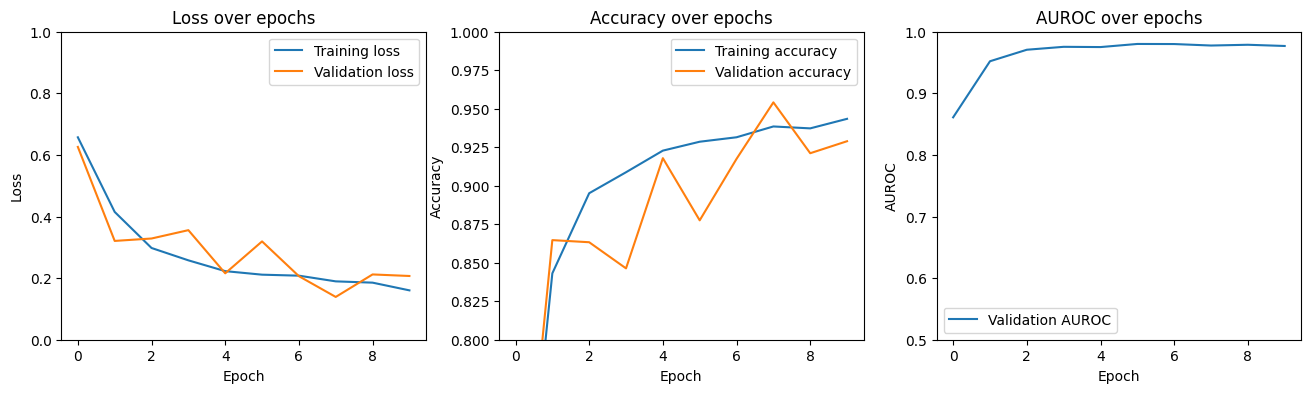

In [29]:
# 손실, 정확도, AUROC 그래프 그리기
plt.figure(figsize=(16, 4))

# 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)  # y축 범위 설정
plt.legend()

# 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # y축 범위 설정
plt.legend()

# AUROC 그래프
plt.subplot(1, 3, 3)
plt.plot(val_aurocs, label='Validation AUROC')
plt.title('AUROC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.ylim(0.5, 1.0)  # y축 범위 설정
plt.legend()

plt.show()

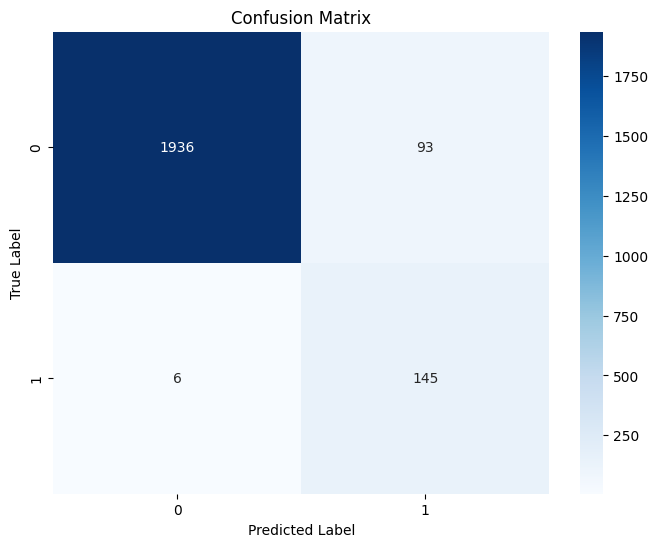

Accuracy: 0.9546
Precision: 0.6092
Recall: 0.9603
F1 Score: 0.7455
Optimal Threshold (Youden Index): 0.82606554


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# 모델을 평가 모드로 설정
model.eval()

# 모든 확률과 레이블을 저장할 리스트 초기화
all_preds_probs = []
all_labels = []

# 테스트 데이터에 대한 예측 수행 (확률만 계산)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).view(-1)  # 시그모이드 함수 적용
        all_preds_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 예측 확률과 실제 레이블을 사용하여 ROC 커브 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_preds_probs)

# Youden의 지수 계산
youden_index = tpr - fpr

# 최대 Youden 지수를 가진 임계값 찾기
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

# 최적 임계값을 사용하여 예측 수행
all_predictions = (np.array(all_preds_probs) > optimal_threshold).astype(int)

# 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 성능 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print("Optimal Threshold (Youden Index):", optimal_threshold)

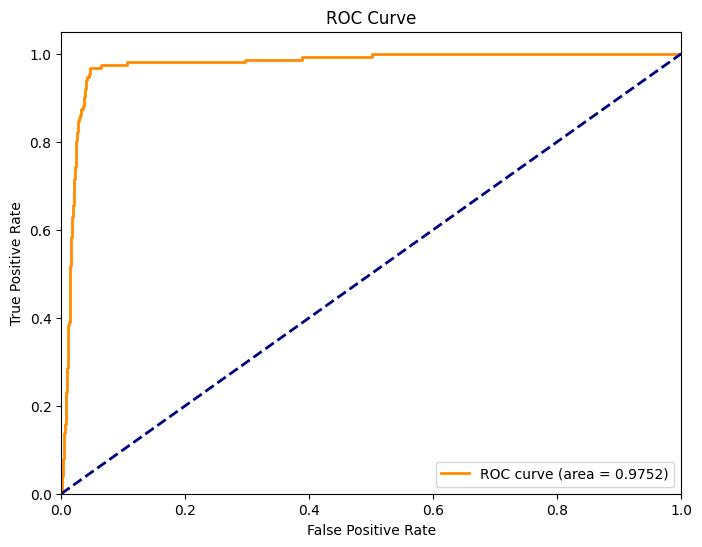

AUROC: 0.9752


In [31]:
# 예측 확률을 저장할 리스트
all_preds_probs = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, _ = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.4f}')


## 2-3 모델 타겟 예측

In [41]:
# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_sph_lead1.npy')


# 타겟의 라벨데이터 
labels = df_sph['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
target_X = torch.Tensor(lead1_signals_normalized)
target_y = torch.Tensor(labels).long()  



# 데이터 분할
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 채널 수를 1로 추가_GOOD
#X_train = X_train.unsqueeze(1)
#X_val = X_val.unsqueeze(1)
#X_test = X_test.unsqueeze(1)

target_X=target_X.unsqueeze(1)



# DataLoader 생성
#train_data = TensorDataset(X_train, y_train)
#val_data = TensorDataset(X_val, y_val)
#test_data = TensorDataset(X_test, y_test)

target_data=TensorDataset(target_X, target_y)

batch_size = 32

#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#val_loader = DataLoader(val_data, batch_size=batch_size)
#test_loader = DataLoader(test_data, batch_size=batch_size)

target_data_loader=DataLoader(target_data, shuffle=True, batch_size=batch_size)

In [42]:
# 테스트 데이터 루프
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, labels in tqdm(target_data_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, np.round(test_preds))
test_auroc = roc_auc_score(test_targets, test_preds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}% - Test AUROC: {test_auroc:.4f}')

Testing: 100%|██████████| 806/806 [00:03<00:00, 210.43it/s]


Test Accuracy: 97.38% - Test AUROC: 0.5000


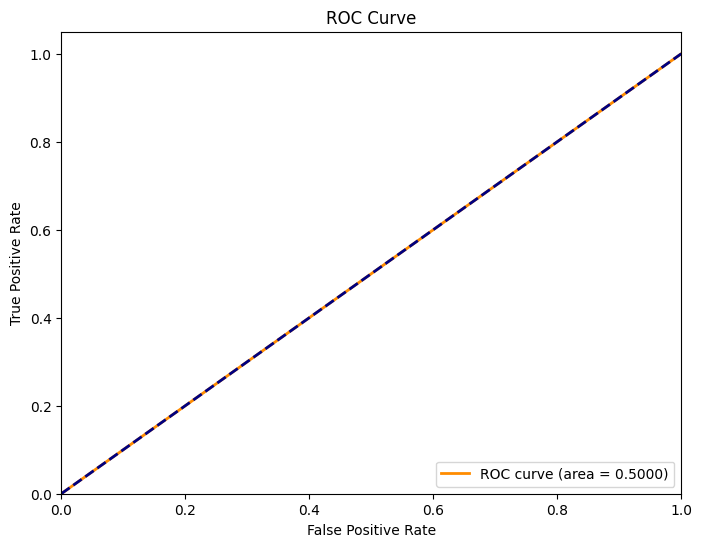

AUROC: 0.5000


In [43]:
# 예측 확률을 저장할 리스트
all_preds_probs = []
all_labels = []
# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, labels in target_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        all_labels.extend(labels.cpu().numpy())
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, thresholds  = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.4f}')

### 실험용 공간

In [26]:
#언더 샘플링 적용해보기 



# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df_ptb['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
y = torch.Tensor(labels).long()  

# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y , test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create an undersampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and transform the data
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

X_train_under=torch.Tensor(X_train_under)
y_train_under=torch.Tensor(y_train_under)
# Convert undersampled data to PyTorch DataLoader
#train_data_under = TensorDataset(torch.Tensor(X_train_under), torch.Tensor(y_train_under))
#train_loader_under = DataLoader(train_data_under, batch_size=batch_size, shuffle=True)


# 채널 수를 1로 추가_GOOD
#X_train= X_train.unsqueeze(1)
X_train_under=X_train_under.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
#train_data = TensorDataset(X_train, y_train)
train_data_under = TensorDataset(X_train_under,y_train_under)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data_under , shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)



In [24]:
## 논문의 모델을 기반으로 만든 모델 

class Custom1DCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self):
        super(Custom1DCNNWithBatchNormAndDropout, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.5)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x

In [44]:
# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom1DCNNWithBatchNormAndDropout().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
# # 각 레이블에 따라 다르게 가중치 부여
#weights = torch.where(labels == 0, torch.tensor(0.1), torch.tensor(0.9))
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_aurocs = []

# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, np.round(train_preds))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    loss_check=[]
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    #print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation AUROC: {val_auroc:.4f}')
    val_aurocs.append(val_auroc)

Epoch 1/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 57.17it/s]


Epoch [1/10] - Validation AUROC: 0.7270


Epoch 2/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 60.05it/s]


Epoch [2/10] - Validation AUROC: 0.9039


Epoch 3/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 62.61it/s]


Epoch [3/10] - Validation AUROC: 0.9741


Epoch 4/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.71it/s]


Epoch [4/10] - Validation AUROC: 0.9756


Epoch 5/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.61it/s]


Epoch [5/10] - Validation AUROC: 0.9795


Epoch 6/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.68it/s]


Epoch [6/10] - Validation AUROC: 0.9772


Epoch 7/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.53it/s]


Epoch [7/10] - Validation AUROC: 0.9786


Epoch 8/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.45it/s]


Epoch [8/10] - Validation AUROC: 0.9775


Epoch 9/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 61.40it/s]


Epoch [9/10] - Validation AUROC: 0.9810


Epoch 10/10 - Training: 100%|██████████| 76/76 [00:01<00:00, 57.24it/s]


Epoch [10/10] - Validation AUROC: 0.9810


In [45]:
# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_sph_lead1.npy')


# 타겟의 라벨데이터 
labels = df_sph['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
target_X = torch.Tensor(lead1_signals_normalized)
target_y = torch.Tensor(labels).long()  


# Create an undersampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and transform the data
X_train_under, y_train_under = undersampler.fit_resample(target_X, target_y)

X_train_under=torch.Tensor(X_train_under)
y_train_under=torch.Tensor(y_train_under)

# 데이터 분할
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 채널 수를 1로 추가_GOOD
#X_train = X_train.unsqueeze(1)
#X_val = X_val.unsqueeze(1)
#X_test = X_test.unsqueeze(1)

X_train_under=X_train_under.unsqueeze(1)



# DataLoader 생성
#train_data = TensorDataset(X_train, y_train)
#val_data = TensorDataset(X_val, y_val)
#test_data = TensorDataset(X_test, y_test)

target_data=TensorDataset(X_train_under, y_train_under)

batch_size = 32

#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#val_loader = DataLoader(val_data, batch_size=batch_size)
#test_loader = DataLoader(test_data, batch_size=batch_size)

target_data_loader=DataLoader(target_data, shuffle=True, batch_size=batch_size)

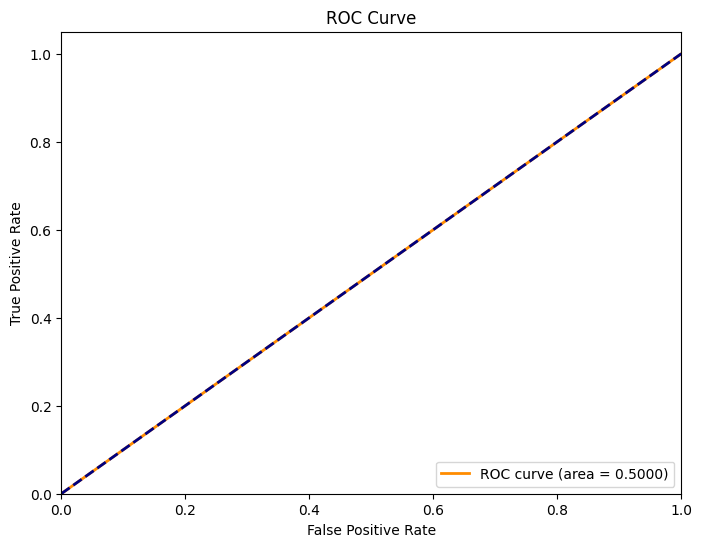

AUROC: 0.5000


In [46]:
# 예측 확률을 저장할 리스트
all_preds_probs = []
all_labels = []
# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, labels in target_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        all_labels.extend(labels.cpu().numpy())
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, thresholds  = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.4f}')